<a href="https://colab.research.google.com/github/vforjj/AI-ML-Review/blob/main/ch38_%5B%EC%8B%A4%EC%8A%B538%5D_Online_News_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D%EA%B3%BC_News_%EC%BD%98%ED%85%90%EC%B8%A0_%ED%92%88%EC%A7%88_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch38.[실습38] Online News 데이터 분석과 News 콘텐츠 품질 개선

### 데이터 분석 목적
    - News들의 흥행(shares) 수를 예측한다.
    - 소비자 Feedback이 좋은 News의 특성을 분석한다.
    - 분석 내용을 기반으로 News 퀄리티를 높인다.
   
### Key Point
    - Continuous 와 Categorical 데이터 분석과 통계 검정
    - Data Column이 많은 경우 EDA 접근 방법
    - Regression Model 학습과 최적화 방법


In [ ]:
!pip install --upgrade pandas-profiling
# 런타임 재실행 필수!

In [ ]:
!pip install shap

In [ ]:
!pip install scikit-optimize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
import pandas_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kruskal
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor


# library for machine learning
import sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn.svm import LinearSVR, SVR

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

import shap

%matplotlib inline

<ipython-input-2-1099fafc9e3c>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## 1. Data Processing 1

### 1-1 Data Load

In [ ]:
path_lecture = "./drive/MyDrive/MLSignature/Lecture/Part4/ch38/"
random_state = 1234

In [ ]:
df = pd.read_csv(path_lecture + "data/OnlineNewsPopularity.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [ ]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

### 1-2 Duplicated Data 확인

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [ ]:
df.info()

In [ ]:
# url을 제외한 column name에 공백이 추가되어 있음. 제거 진행.
df.columns = [x.replace(" ", "") for x in list(df.columns)]

In [ ]:
df.info()

In [ ]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

In [ ]:
# categorical -> object
# unique value와 data description을 함께 확인하며, heuristic 하게 결정.

list_casting_as_object = ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world", "weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday", "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday", "is_weekend"]
for column_name in list_casting_as_object:
  df[column_name] = df[column_name].astype("string")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['string','object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
target_column = "shares"
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

61
15
45


In [ ]:
df.columns[df.isna().sum() != 0]

Index([], dtype='object')

#### Summary of Data Set
##### - Number of Variables : 61
    categorical variables : 15
    numeric variables : 45
    target variables : 1
##### - Number of observations : 39644
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

In [ ]:
df[target_column].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

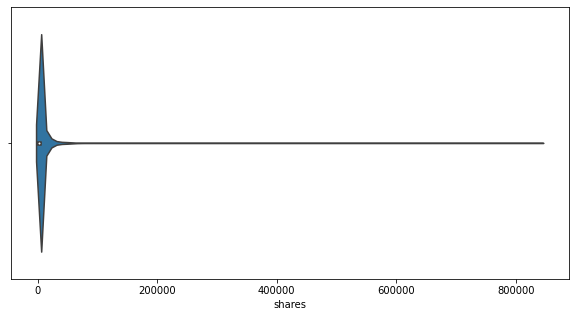

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x=target_column, data=df)
plt.show()

In [ ]:
# 분포 확인이 어렵기 때문에 특정 condition 아래의 값들만 관찰
# IQR과 maximum outlier 경계 찾기
quantile_75 = df[target_column].quantile(0.75)
quantile_25 = df[target_column].quantile(0.25)
IQR = quantile_75 - quantile_25
maximum_outlier_boundary = quantile_75 + 1.5 * IQR

# minimum outlier boundary 생성시 주의
min = df[target_column].min()
candidate_m_o_b = quantile_25 - 1.5 * IQR
minimum_outlier_boundary = candidate_m_o_b if candidate_m_o_b > min else min

print("quantile 75% : ", quantile_75)
print("quantile 25% : ", quantile_25)
print("IQR : ", IQR)
print("maximum_outlier_boundary", maximum_outlier_boundary)
print("minimum_outlier_boundary", minimum_outlier_boundary)

quantile 75% :  2800.0
quantile 25% :  946.0
IQR :  1854.0
maximum_outlier_boundary 5581.0
minimum_outlier_boundary 1


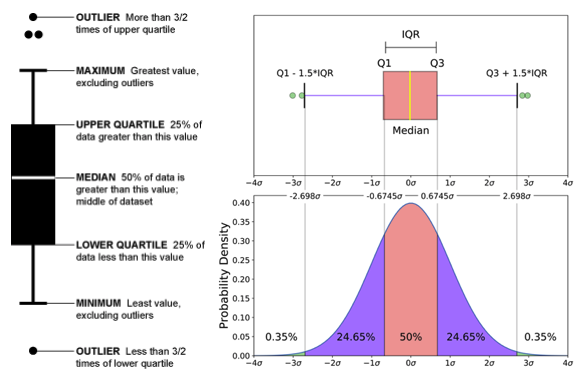

In [ ]:
Image(path_lecture + "img/boxplot_and_iqr.png")

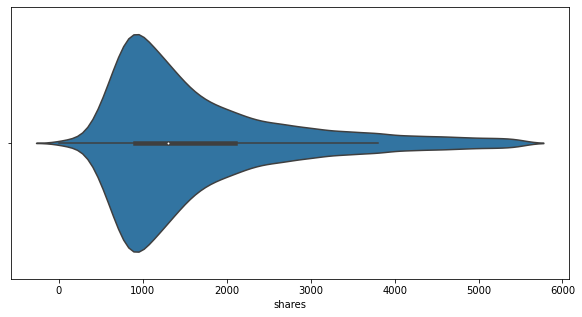

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x=target_column, data=df[df.shares < maximum_outlier_boundary])
plt.show()

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_categorical_columns].nunique().sort_values()

data_channel_is_lifestyle            2
data_channel_is_entertainment        2
data_channel_is_bus                  2
data_channel_is_socmed               2
data_channel_is_tech                 2
data_channel_is_world                2
weekday_is_monday                    2
weekday_is_tuesday                   2
weekday_is_wednesday                 2
weekday_is_thursday                  2
weekday_is_friday                    2
weekday_is_saturday                  2
weekday_is_sunday                    2
is_weekend                           2
url                              39644
dtype: int64

In [ ]:
# url은 unique 수가 전체 데이터 수와 동일하므로 제거.
df = df.drop("url", axis=1)
list_categorical_columns.remove("url")

##### Column별 분포 확인

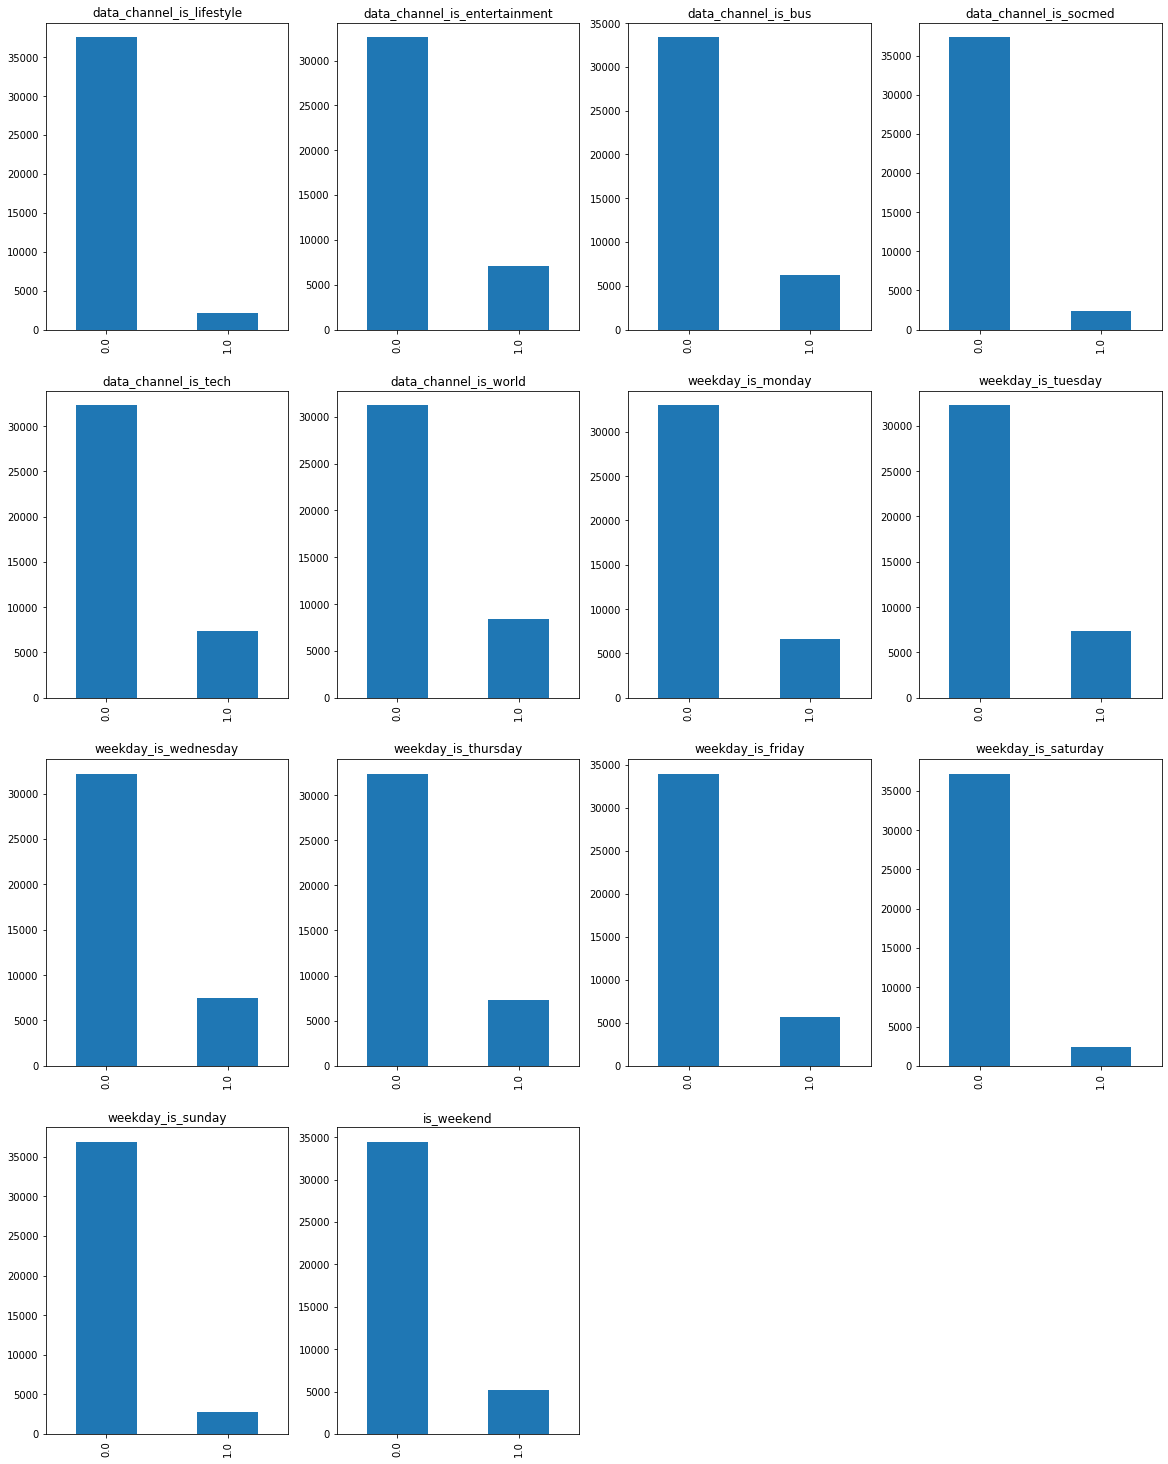

In [ ]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

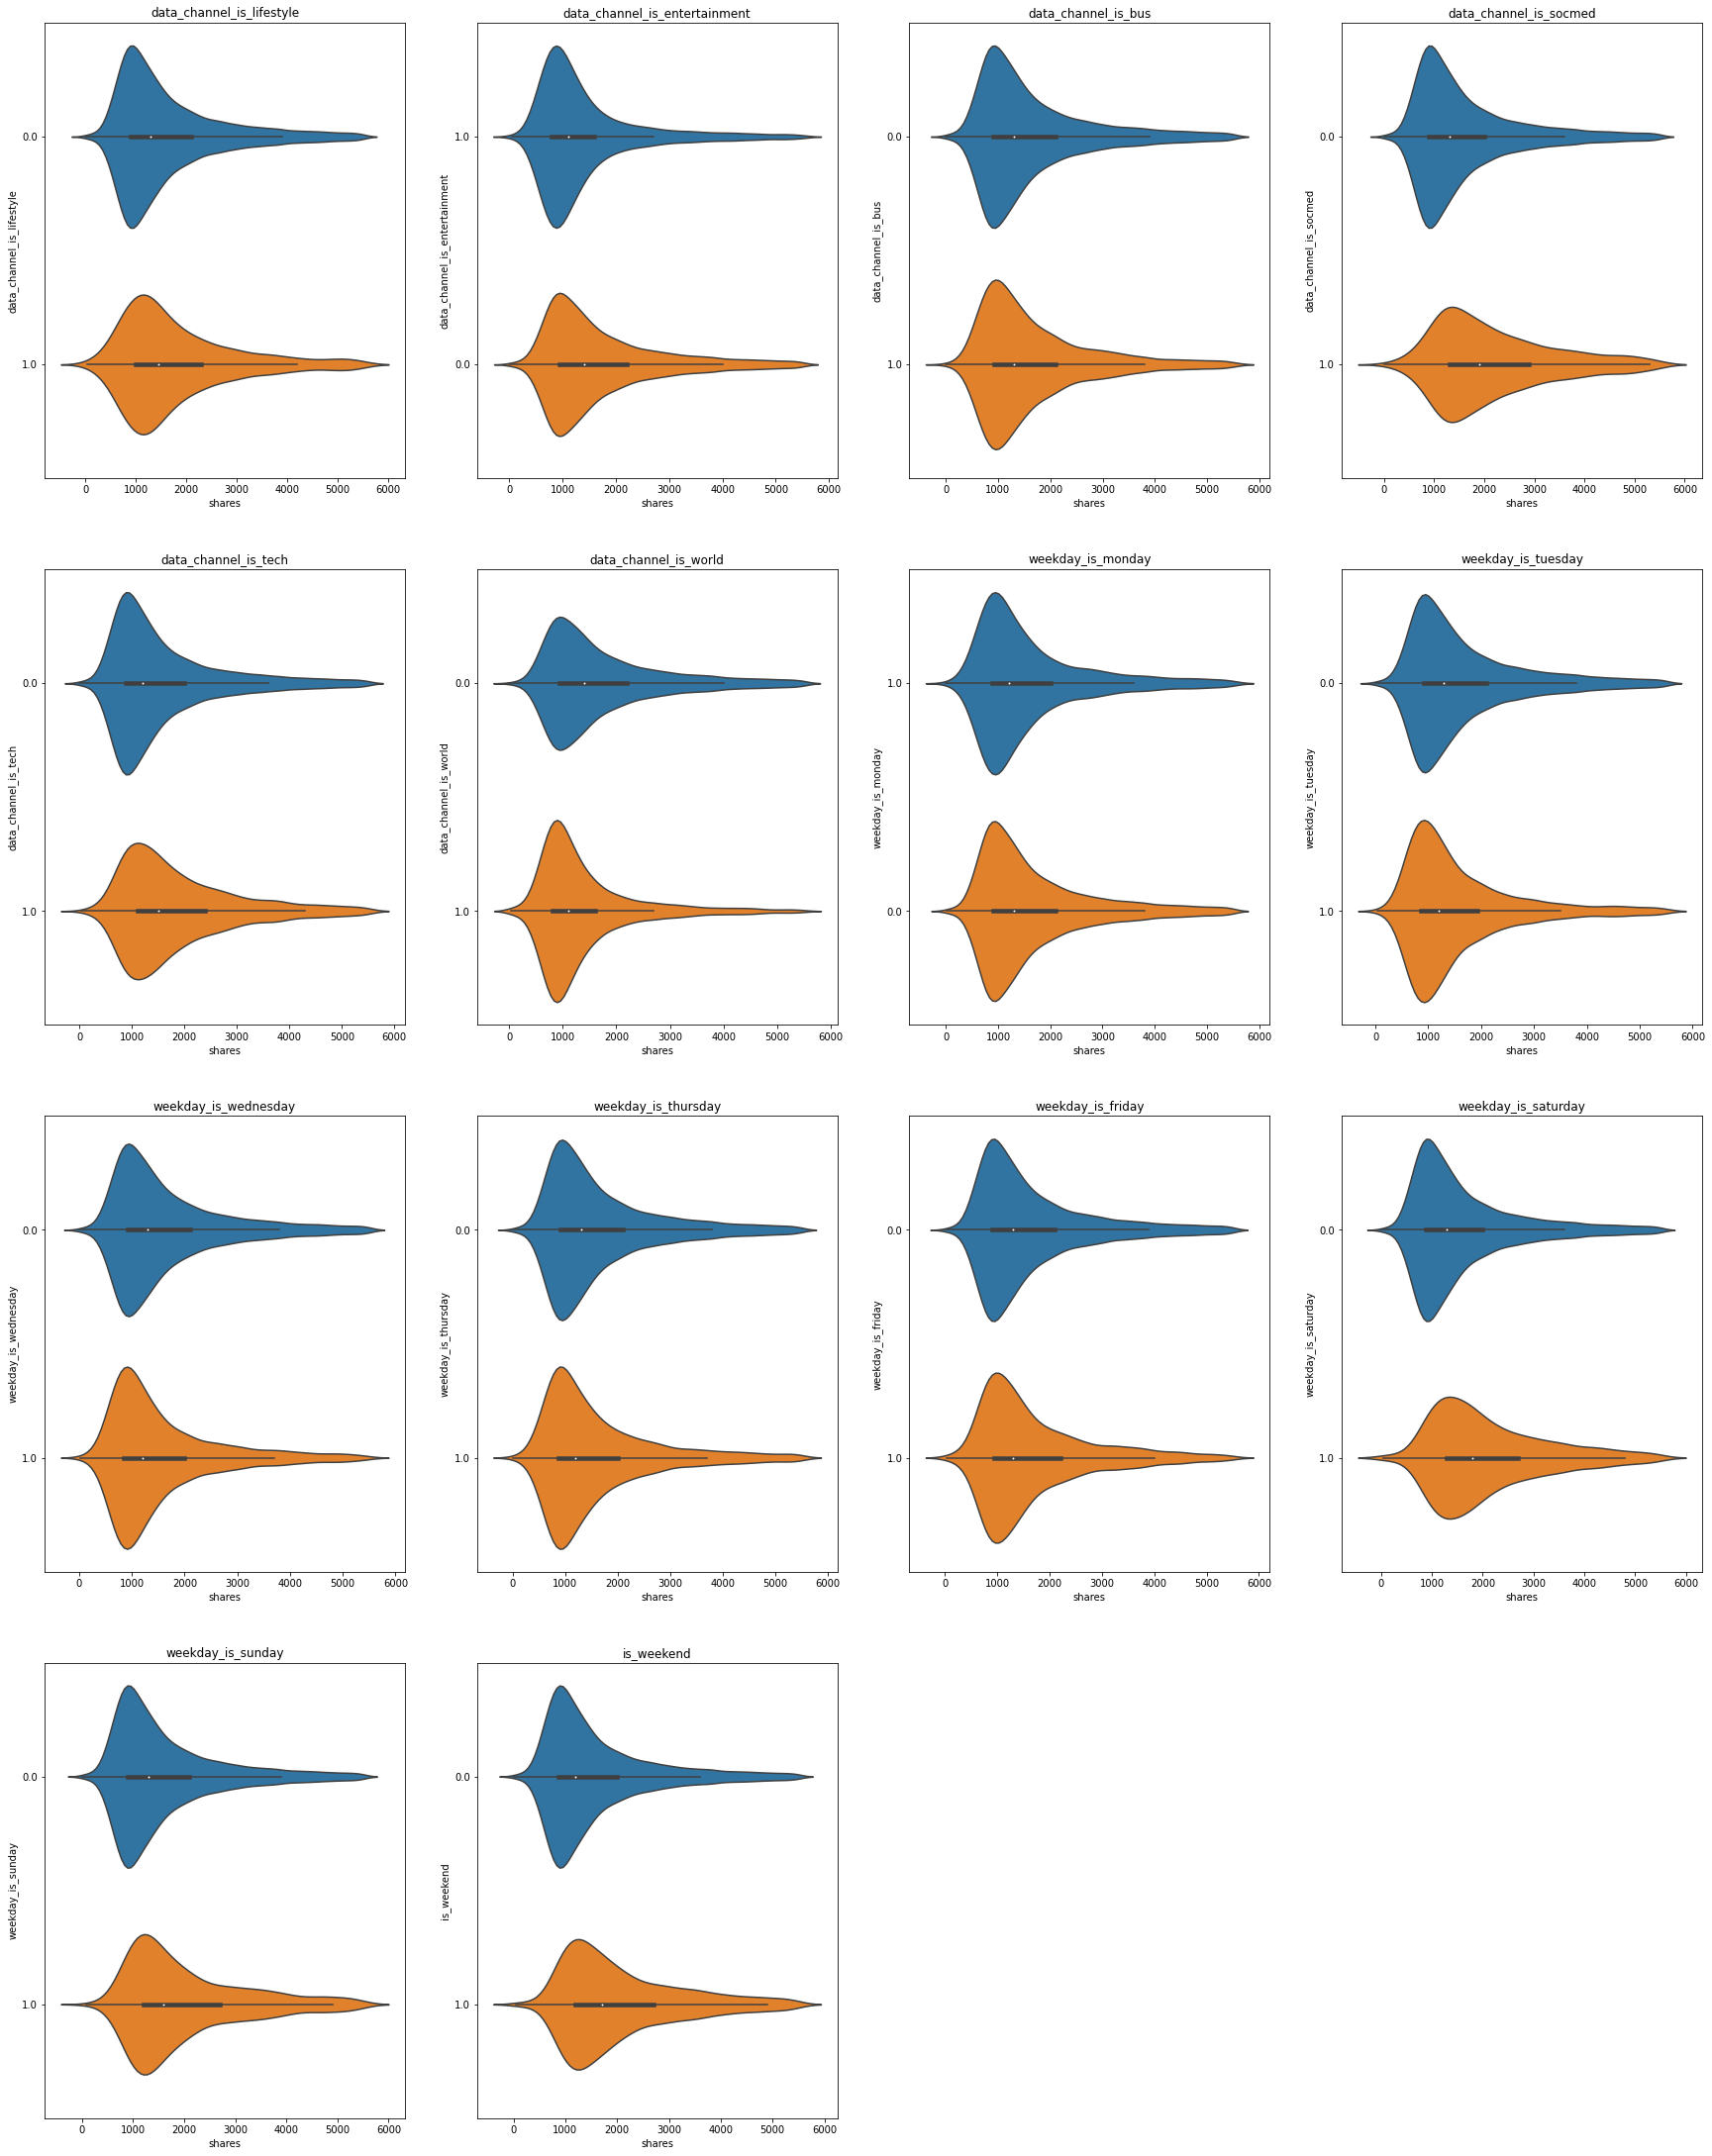

In [ ]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,4,x)
    x = x+1
    # 종속변수 데이터 range가 넓기 때문에, 제대로된 데이터 관측을 위해 condition을 준 뒤에 관찰한다
    # 위에서 구한 IQR을 활용한 maximum_outlier_boundary을 활용
    sns.violinplot(data=df[df.shares < maximum_outlier_boundary], x=target_column, y=column_name)
    plt.title(column_name)
plt.show()

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 shares 에 따른 categorical column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)

정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)



##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [ ]:
list_meaningful_column_by_kruskall = []

for column_name in list_categorical_columns:
  list_value = df[column_name].unique()
  list_by_value = []
  for value in list_value:
      df_tmp = df[df[column_name] == value][target_column].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_categorical_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

data_channel_is_lifestyle ,  71.76317533570466 ,  2.4263841118997056e-17
data_channel_is_entertainment ,  521.4658281968884 ,  2.030637547852609e-115
data_channel_is_bus ,  13.291515828542224 ,  0.00026660983919792535
data_channel_is_socmed ,  511.3350002765733 ,  3.24905877363164e-113
data_channel_is_tech ,  354.16764078556577 ,  5.243145249401652e-79
data_channel_is_world ,  1124.7694540680977 ,  1.3659644068103466e-246
weekday_is_monday ,  15.287932248556803 ,  9.230431802387868e-05
weekday_is_tuesday ,  66.80579485531698 ,  2.996160786091953e-16
weekday_is_wednesday ,  91.83535269929703 ,  9.419653082775944e-22
weekday_is_thursday ,  45.54903270288847 ,  1.4886518032041e-11
weekday_is_friday ,  5.29792273409253 ,  0.021350872257249198
weekday_is_saturday ,  469.78561757522897 ,  3.567959565763735e-104
weekday_is_sunday ,  383.89110011040447 ,  1.7693705848986513e-85
is_weekend ,  912.5106029159526 ,  1.8714865175770197e-200
all numerical columns :  14
selected columns by kruskal : 

##### Insight
1.   모든 cateogircal data는 shares와 유의미한 관계를 갖음을 확인되었으며, 추후 ML 학습시 모두 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_numeric_columns].nunique().sort_values()

num_keywords                       10
n_tokens_title                     20
kw_min_min                         26
min_positive_polarity              33
kw_max_max                         35
max_positive_polarity              38
max_negative_polarity              49
num_videos                         53
min_negative_polarity              54
num_self_hrefs                     59
num_imgs                           91
num_hrefs                         133
abs_title_subjectivity            532
abs_title_sentiment_polarity      653
title_subjectivity                673
timedelta                         724
title_sentiment_polarity          813
kw_min_max                       1021
kw_max_min                       1076
self_reference_max_shares        1137
self_reference_min_shares        1255
n_non_stop_words                 1451
rate_negative_words              2284
rate_positive_words              2284
n_tokens_content                 2406
self_reference_avg_sharess       8626
global_rate_

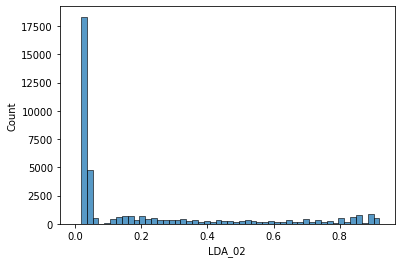

In [ ]:
# LDA_02 unique 수가 데이터 수와 유사하기 때문에, 한 번 더 histplot으로 검정
sns.histplot(x="LDA_02", data=df)

# numerical 하며 데이터 분포가 넒고 다양하게 구성되어 있으며, 불필요한 컬럼이 아님

##### Column별 분포 확인

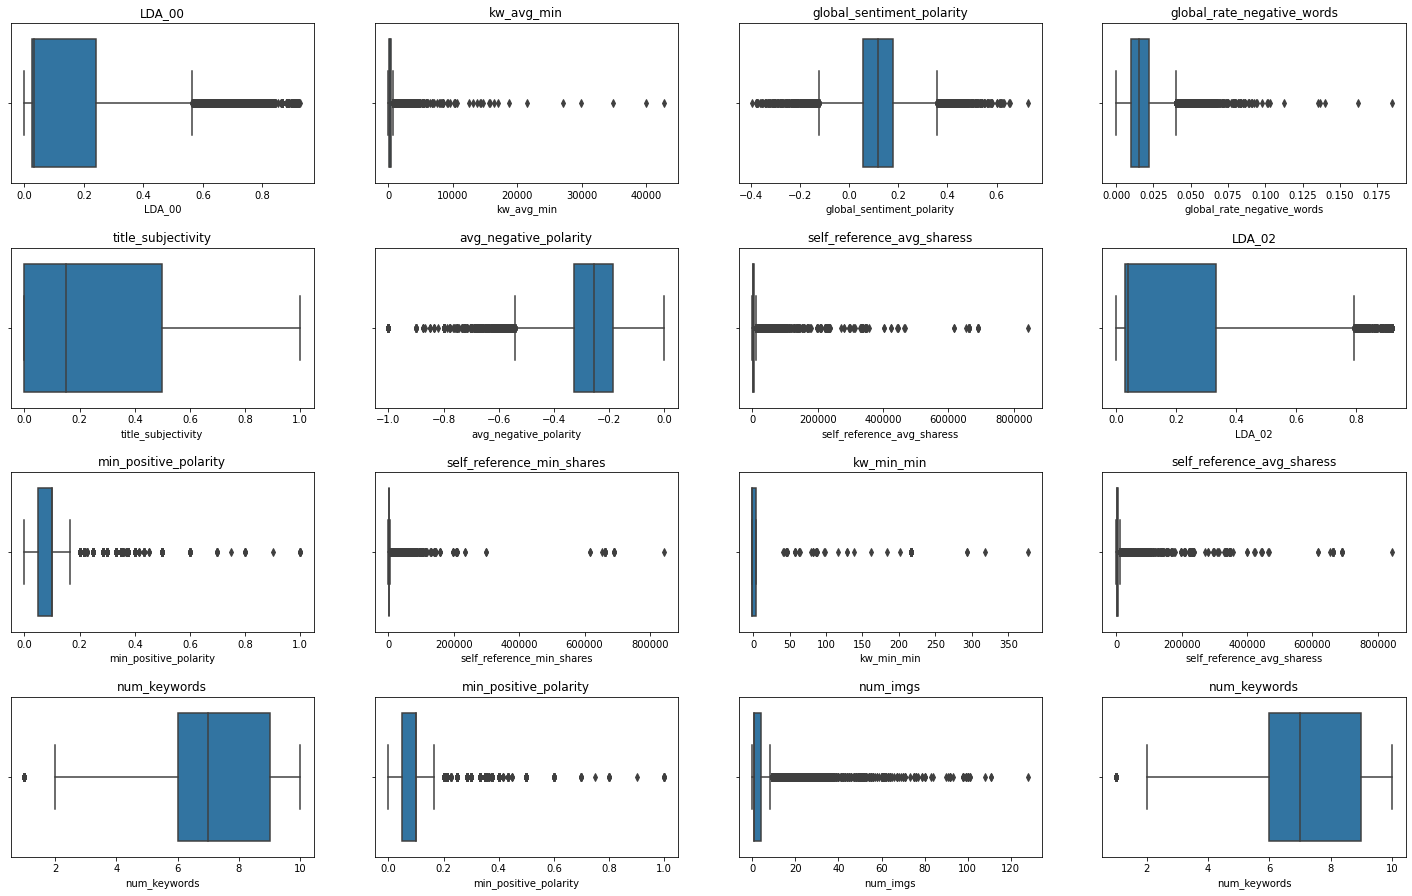

In [ ]:
# numeric column 별 분포 확인
list_columns_randomly = random.choices(list_numeric_columns, k=16)
plt.figure(figsize=(25,15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_columns_randomly:
    plt.subplot(5,4,x)
    x = x+1
    sns.boxplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [ ]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

timedelta skew :  0.12049971449966648 kur :  -1.257183334987622
n_tokens_title skew :  0.16531412149825878 kur :  -0.0009009193260514081
n_tokens_content skew :  2.9453104924305262 kur :  19.47580370021696
n_unique_tokens skew :  198.64759905589614 kur :  39518.847181370744
n_non_stop_words skew :  198.78492363836094 kur :  39555.30553163253
n_non_stop_unique_tokens skew :  198.43578588161438 kur :  39462.715968413024
num_hrefs skew :  4.01334296901664 kur :  35.5017035120209
num_self_hrefs skew :  5.172555383625405 kur :  56.16422073379269
num_imgs skew :  3.9464465167353917 kur :  24.522501415540955
num_videos skew :  7.01926718721791 kur :  74.06592030939247
average_token_length skew :  -4.575838406993438 kur :  22.177501180859796
num_keywords skew :  -0.147245680432572 kur :  -0.8059468577791953
kw_min_min skew :  2.374857418958583 kur :  3.6593898852689097
kw_max_min skew :  35.32709700409423 kur :  2099.805749515707
kw_avg_min skew :  31.30492356891744 kur :  1592.0433912436768
k

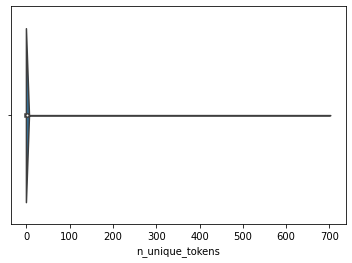

In [ ]:
# kurtosis is 39518.847181370744
sns.violinplot(x="n_unique_tokens", data=df)

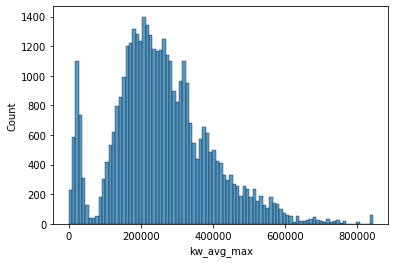

In [ ]:
# kurtosis is 0.8302649041039603
sns.histplot(x="kw_avg_max", data=df)

##### Correlation Analysis

<AxesSubplot:>

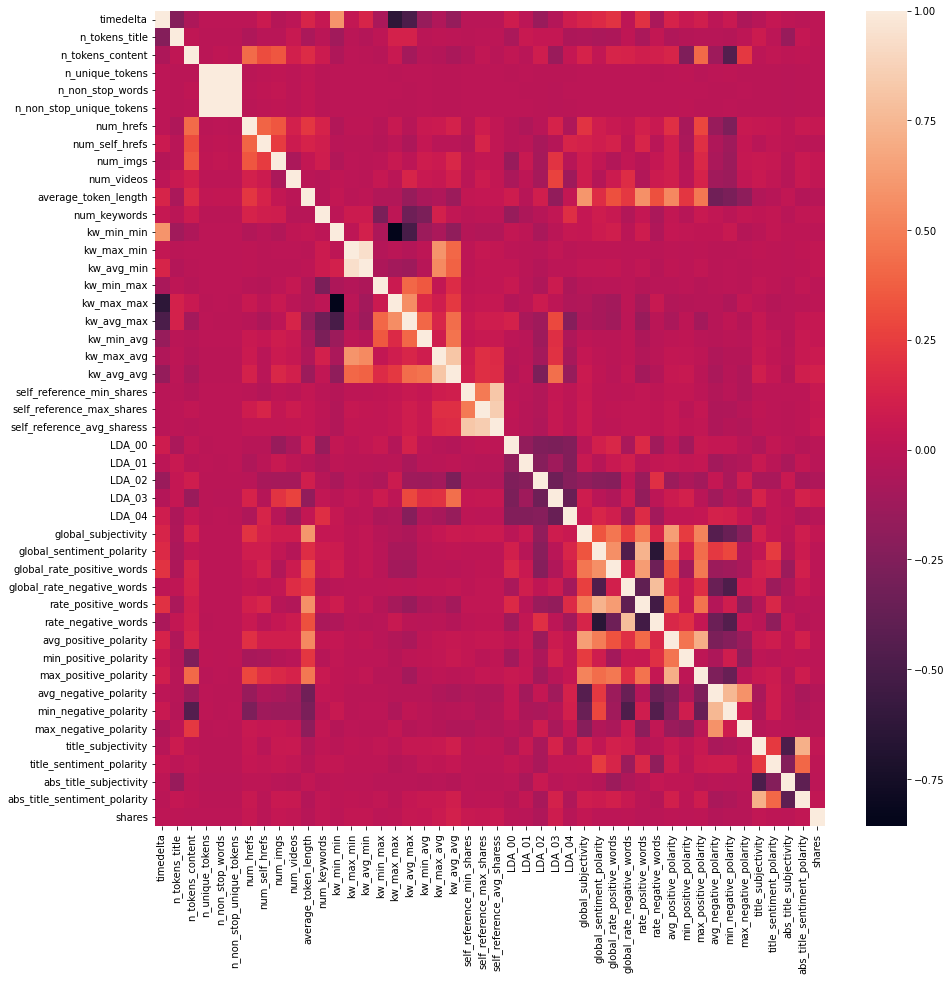

In [ ]:
df_corr = df[list_numeric_columns + [target_column]].corr()
plt.figure(figsize=(15,15))
sns.heatmap(df_corr)

In [ ]:
# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
index_corr_over_90 = np.where((abs(df_corr) > 0.9) & (df_corr != 1))
index_corr_over_90

(array([ 3,  3,  4,  4,  5,  5, 13, 14]),
 array([ 4,  5,  3,  5,  3,  4, 14, 13]))

In [ ]:
len_corr_over_90 = len(index_corr_over_90[0])
left_columns = df_corr.columns[index_corr_over_90[0]]
right_columns = df_corr.columns[index_corr_over_90[1]]
for index in range(len_corr_over_90):
  print(left_columns[index], "<->", right_columns[index])

n_unique_tokens <-> n_non_stop_words
n_unique_tokens <-> n_non_stop_unique_tokens
n_non_stop_words <-> n_unique_tokens
n_non_stop_words <-> n_non_stop_unique_tokens
n_non_stop_unique_tokens <-> n_unique_tokens
n_non_stop_unique_tokens <-> n_non_stop_words
kw_max_min <-> kw_avg_min
kw_avg_min <-> kw_max_min


In [ ]:
# correlation이 0.9 이상인 경우의 pvalue 검정
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
list_not_valid = []
for index in range(len_corr_over_90):
    statistic, pvalue = stats.pearsonr(df.loc[:,left_columns[index]], df.loc[:,right_columns[index]])
    print("%s<->%s : %f %f"%(left_columns[index],right_columns[index] , statistic, pvalue))
    if (pvalue > 0.05):
        list_not_valid.append(column_name)
print("end")
print(len(list_not_valid), " is not valids")

n_unique_tokens<->n_non_stop_words : 0.999572 0.000000
n_unique_tokens<->n_non_stop_unique_tokens : 0.999852 0.000000
n_non_stop_words<->n_unique_tokens : 0.999572 0.000000
n_non_stop_words<->n_non_stop_unique_tokens : 0.999532 0.000000
n_non_stop_unique_tokens<->n_unique_tokens : 0.999852 0.000000
n_non_stop_unique_tokens<->n_non_stop_words : 0.999532 0.000000
kw_max_min<->kw_avg_min : 0.940529 0.000000
kw_avg_min<->kw_max_min : 0.940529 0.000000
end
0  is not valids


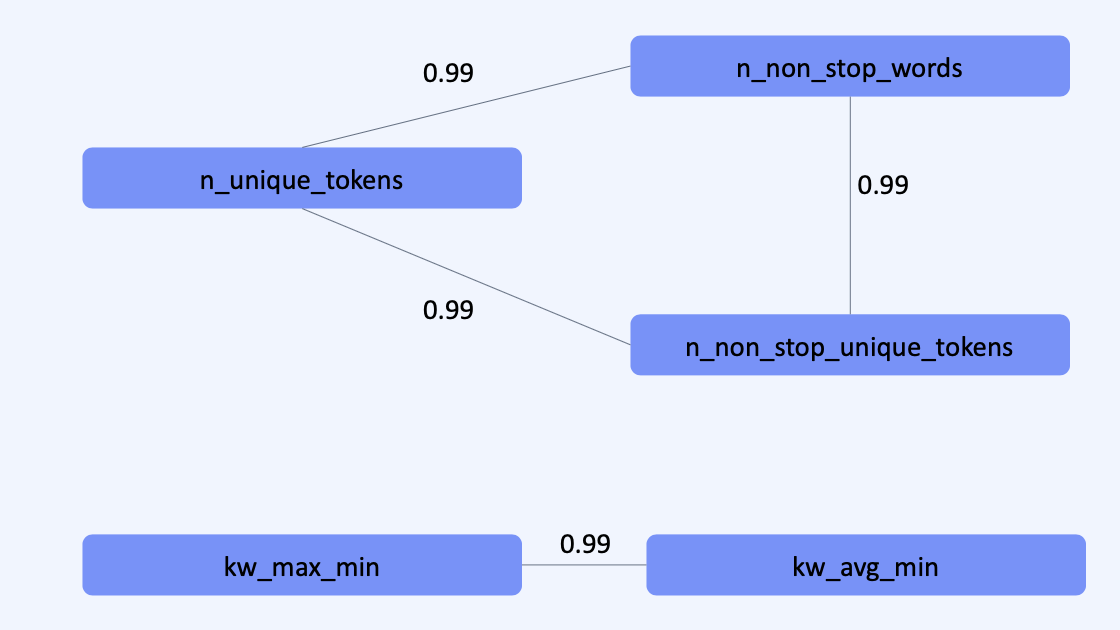

In [ ]:
Image(path_lecture + "img/high_correlation.png")

In [ ]:
list_removed_by_correlation = ["n_unique_tokens", "kw_max_min"]

##### VIF Analysis
-   일반적으로는는 10이상인인 경우 다중공선성이이 있다고 가정하지만만, 본 실습은 20이상으로 가정


In [ ]:
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [ ]:
caculate_vif(df_vif)
# 한 개 씩 데이터를 지우면서 확인 (반복작업)

,VIF_Factor,Feature
0,2.077760,timedelta
1,1.127667,n_tokens_title
2,3.312108,n_tokens_content
3,13531.754978,n_unique_tokens
4,3589.197416,n_non_stop_words
5,8335.065756,n_non_stop_unique_tokens
6,1.712927,num_hrefs
7,1.378726,num_self_hrefs
8,1.651555,num_imgs
9,1.246346,num_videos


In [ ]:
df_vif2 = df_vif.drop(["n_unique_tokens", "kw_max_max", "LDA_03"], axis=1).copy()
del df_vif
#caculate_vif(df_vif2)

In [ ]:
df_vif3 = df_vif2.drop(["n_non_stop_unique_tokens", "average_token_length", "kw_avg_avg", "self_reference_avg_sharess", "global_subjectivity", "global_rate_positive_words", "global_rate_negative_words", "rate_positive_words","avg_positive_polarity","max_positive_polarity"], axis=1).copy()
del df_vif2
#caculate_vif(df_vif3)

In [ ]:
df_vif4 = df_vif3.drop(["n_tokens_title","avg_negative_polarity"], axis=1).copy()
del df_vif3
vif_final = caculate_vif(df_vif4)
vif_final

,VIF_Factor,Feature
0,6.216382,timedelta
1,4.659982,n_tokens_content
2,1.036994,n_non_stop_words
3,2.911695,num_hrefs
4,2.284099,num_self_hrefs
5,1.806476,num_imgs
6,1.305289,num_videos
7,13.124059,num_keywords
8,2.021188,kw_min_min
9,11.141383,kw_max_min


In [ ]:
# list_removed_by_correlation에서 상관관계가 높아 제거하려던 컬럼들도 vif 분석에서 제거됨
list_numeric_feature_by_vif = list(vif_final["Feature"].values)
print(list_numeric_feature_by_vif)
print(len(list_numeric_feature_by_vif))

['timedelta', 'n_tokens_content', 'n_non_stop_words', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_04', 'global_sentiment_polarity', 'rate_negative_words', 'min_positive_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity']
30


In [ ]:
del df_vif4
del vif_final

##### 다중공선성 정리
- 어떤 독립 변수가 다른 독립 변수들과 완벽한 “선형 독립”이 아닌 경우를 말함
- 쉽게 설명하면, 사용된 모형의 일부 설명 변수가 다른 설명 변수와 상관관계 정도가 높음
- 다중 공선성은 데이터 분석 시 부정적인 영향을 미쳐, 설명력이 약해지고  standar error가 증가할 수 있음
- 구하는 절대적인 방법은 없으나 아래와 같이 3가지 방법을 많이 활용
1. 결정계수와 유의확률을 활용한 다중공선성 확인
2. 상관계수 및 산점도(scatter plot)를 활용한 확인
3. VIF 통한 다중공선성 확인

https://ko.wikipedia.org/wiki/다중공선성

##### Insight
1.   다중공선성 확인이 필요했으며, 상관 분석과 VIF 분석을 병행
3.   numercial data 간의 상관관계 중, 매우우 높은 상관 관계를 갖는 경우가 존재
3.   VIF 분석 결과 제거한 numerical data는 총 15개이며, 높은 상관관계를 보인 데이터도 포함되어 제거됨. (44개 -> 29개)
4.   numerical data 들은 skew 값보다 kurtosis 값이 큰 경향을 보이는 것들이 존재한다. 이는 preprocessing으로 데이터 분포를 정규화 할 수 있음



### 2-4 EDA with pandas_profiling

In [ ]:
df[[target_column]+list_categorical_columns+list_numeric_feature_by_vif].profile_report().to_file(path_lecture + "data/data_eda_with_pandasprofiling.html")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df = df[[target_column]+list_categorical_columns+list_numeric_feature_by_vif]
# numeric & categorical column define again
list_categorical_columns = list(df.select_dtypes(include=['string','object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

45
14
30


##### Insight
*   EDA를 진행하며 최종 선택된 컬럼 데이터 수 : 44
*   categorical columns : 14
*   numerical columns : 29



## 3. Data Processing 2

### 3-1 Missing Values

In [ ]:
df.isna().sum().sort_values(ascending=False)

shares                           0
kw_min_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
self_reference_min_shares        0
self_reference_max_shares        0
LDA_00                           0
LDA_01                           0
LDA_02                           0
LDA_04                           0
global_sentiment_polarity        0
rate_negative_words              0
min_positive_polarity            0
min_negative_polarity            0
max_negative_polarity            0
title_subjectivity               0
title_sentiment_polarity         0
abs_title_subjectivity           0
kw_max_min                       0
num_keywords                     0
data_channel_is_lifestyle        0
num_videos                       0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech

### 3-2 Feature Transformation

In [ ]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

##### Normalization
*   Standardization과 Normalization은 다른 것.
*   Normalization은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [ ]:
X.head(1)

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,LDA_04,global_sentiment_polarity,rate_negative_words,min_positive_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.040123,0.092562,0.230769,0.1,-0.6,-0.2,0.5,-0.1875,0.0,0.1875


In [ ]:
scaler = MinMaxScaler()
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,LDA_04,global_sentiment_polarity,rate_negative_words,min_positive_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.043273,0.433591,0.230769,0.1,0.4,0.8,0.5,0.40625,0.0,0.1875


MinMaxScaler Review
*   Feature Transformation(Scaling) 기법
*   ( X- (X의 최솟값) ) / ( X의 최댓값 - X의 최솟값 )
*   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
*   https://en.wikipedia.org/wiki/Feature_scaling



In [ ]:
# title_sentiment_polarity 컬럼으로 실습

x_min = df["title_sentiment_polarity"].min()
x_max = df["title_sentiment_polarity"].max()
print(x_min)
print(x_max)

-1.0
1.0


In [ ]:
(df["title_sentiment_polarity"] - x_min)/(x_max-x_min)

0        0.406250
1        0.500000
2        0.500000
3        0.500000
4        0.568182
           ...   
39639    0.500000
39640    1.000000
39641    0.568182
39642    0.500000
39643    0.625000
Name: title_sentiment_polarity, Length: 39644, dtype: float64

##### One-hot Encoding for categorical column data

In [ ]:
len(X.columns)

44

In [ ]:
X_base = pd.get_dummies(X)
X_base.head(1)

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,LDA_04,global_sentiment_polarity,rate_negative_words,min_positive_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.043273,0.433591,0.230769,0.1,0.4,0.8,0.5,0.40625,0.0,0.1875


In [ ]:
# 기존 cateogircal column data가 모두 [0,1]로 구성되어 있어 변화가 없음
len(X_base.columns)

44

##### 차원 축소
1.   LDA
2.   PCA



In [ ]:
LDA_clf = LinearDiscriminantAnalysis(n_components=2)
X_LDA = LDA_clf.fit_transform(X_base[list_numeric_columns], Y)

In [ ]:
X_LDA.shape

(39644, 2)

In [ ]:
X_LDA

array([[-1.64441734,  0.10829011],
       [-1.20046443,  0.19643762],
       [-0.5680984 ,  0.52520602],
       ...,
       [ 0.975271  ,  0.403258  ],
       [-2.23147965, -0.35530349],
       [-1.36957224, -0.47110746]])

In [ ]:
np.sum(LDA_clf.explained_variance_ratio_)

0.16681119027035662

In [ ]:
X_base[list_numeric_columns].head(1)

,timedelta,n_tokens_content,n_non_stop_words,num_hrefs,num_self_hrefs,num_imgs,num_videos,num_keywords,kw_min_min,kw_max_min,...,LDA_04,global_sentiment_polarity,rate_negative_words,min_positive_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,1.0,0.025844,0.00096,0.013158,0.017241,0.007812,0.0,0.444444,0.002646,0.0,...,0.043273,0.433591,0.230769,0.1,0.4,0.8,0.5,0.40625,0.0,0.1875


<AxesSubplot:xlabel='dimension', ylabel='explained'>

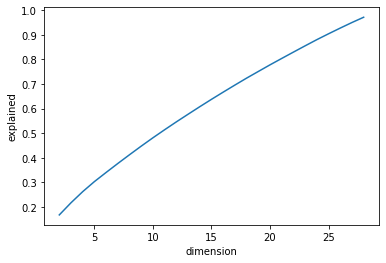

In [ ]:
list_lda_explained_ratio = []
list_dimension = [i for i in range(2,29)]
for i in list_dimension:
    LDA_clf = LinearDiscriminantAnalysis(n_components=i)
    LDA_clf.fit(X_base[list_numeric_columns], Y)
    list_lda_explained_ratio.append(np.sum(LDA_clf.explained_variance_ratio_))
sns.lineplot(data=pd.DataFrame(data={"dimension":list_dimension, "explained":list_lda_explained_ratio}), x="dimension", y="explained")

<AxesSubplot:xlabel='dimension', ylabel='explained'>

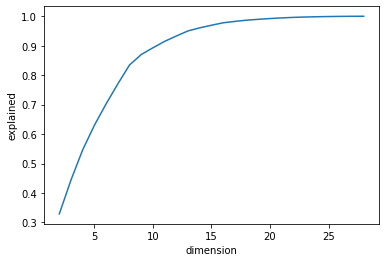

In [ ]:
# pca
list_pca_explained_ratio = []
list_pca_candidate = [i for i in range(2,29)]
for i in list_pca_candidate:
    pca_tmp = PCA(n_components=i)
    pca_tmp.fit(X_base[list_numeric_columns])
    list_pca_explained_ratio.append(np.sum(pca_tmp.explained_variance_ratio_))
sns.lineplot(data=pd.DataFrame(data={"dimension":list_pca_candidate, "explained":list_pca_explained_ratio}), x="dimension", y="explained")

##### insight
- numerical column 차원 축소는 설명력이 90%이상인 경우도 기존 컬럼 수와 큰 차이가 나지 않기 때문에 차원 축소를 하지 않기로 결정(다르게 적용도 가능)
- 개인 판단에 의거하여 더 낮은 설명력을 선택하여, 차원 축소된 데이터를 활용해도 됨

In [ ]:
print(len(X_base))
print(len(X_base.columns))

39644
44


### 3-3 Summary
##### 최종 생성 Feature는 아래와 같은 특성을 가짐
1.   Feature Selection by VIF analysis and Correlation
2.   Normalization(Minmaxscaling)
3.   No Dimension Reduction

##### X_base, Y

## 4. Model Analysis
1.   base model with Feature Selection

### Model Optimization with bayes search  
1. RandomForest


In [ ]:
cv = 3
n_jobs = -1

### 4-1. Base Model Learning

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y, test_size = 0.3, random_state = random_state)

In [ ]:
rf_clf = RandomForestRegressor(max_depth=20)
rf_clf.fit(X_train, y_train)
y_prd = rf_clf.predict(X_validation)
score = mean_squared_error(y_prd, y_validation)**0.5
print("rmse : ", score)

rmse :  10058.338913640444


### 4-2. Optimization 2 : BayesSearchCV

##### BayesSearchCV?
*   Estimator 결정할 때 최적의 Hyper-Parameter를 찾기 위한 방법 중 하나. (일반적으로 3가지 방법이 있으며, GridSearch/RandomSearch/Bayes Search)
*   Bayes System(Algorithm) 기반으로 Hyper-Parameter를 선정하여 반복하며 최적의 값을 찾아주는 방법
*   Cross Validation도 같이 진행되기 떄문에 신뢰할 수 있는 결과물을 얻을 수 있다.
*   scikit learn은 GridSearch와 RandomSearch 만을 지원
*   skopt library를 활용
*   https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

In [ ]:
opt = BayesSearchCV(
    RandomForestRegressor(),
    {
        'max_depth' : (10, 35),
        'n_estimators' : (100,200),
        'min_samples_split' : (2, 6),
        'max_features' : [0.7,0.8,1.0],
        'criterion' : ['squared_error']
    },
    n_iter=16,
    cv=cv,
    verbose=1
)
opt.fit(X_train, y_train)
y_prd = opt.predict(X_validation)
score = mean_squared_error(y_prd, y_validation)**0.5
print("rmse : ", score)




Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
rmse :  9949.82022629592


### 4-2. Model Analysis

##### Feature Importance

In [ ]:
opt.best_params_

OrderedDict([('criterion', 'squared_error'),
             ('max_depth', 10),
             ('max_features', 0.7),
             ('min_samples_split', 6),
             ('n_estimators', 197)])

In [ ]:
# reproduction
reg_rf = RandomForestRegressor(**opt.best_params_)
final_model = reg_rf.fit(X_train, y_train)

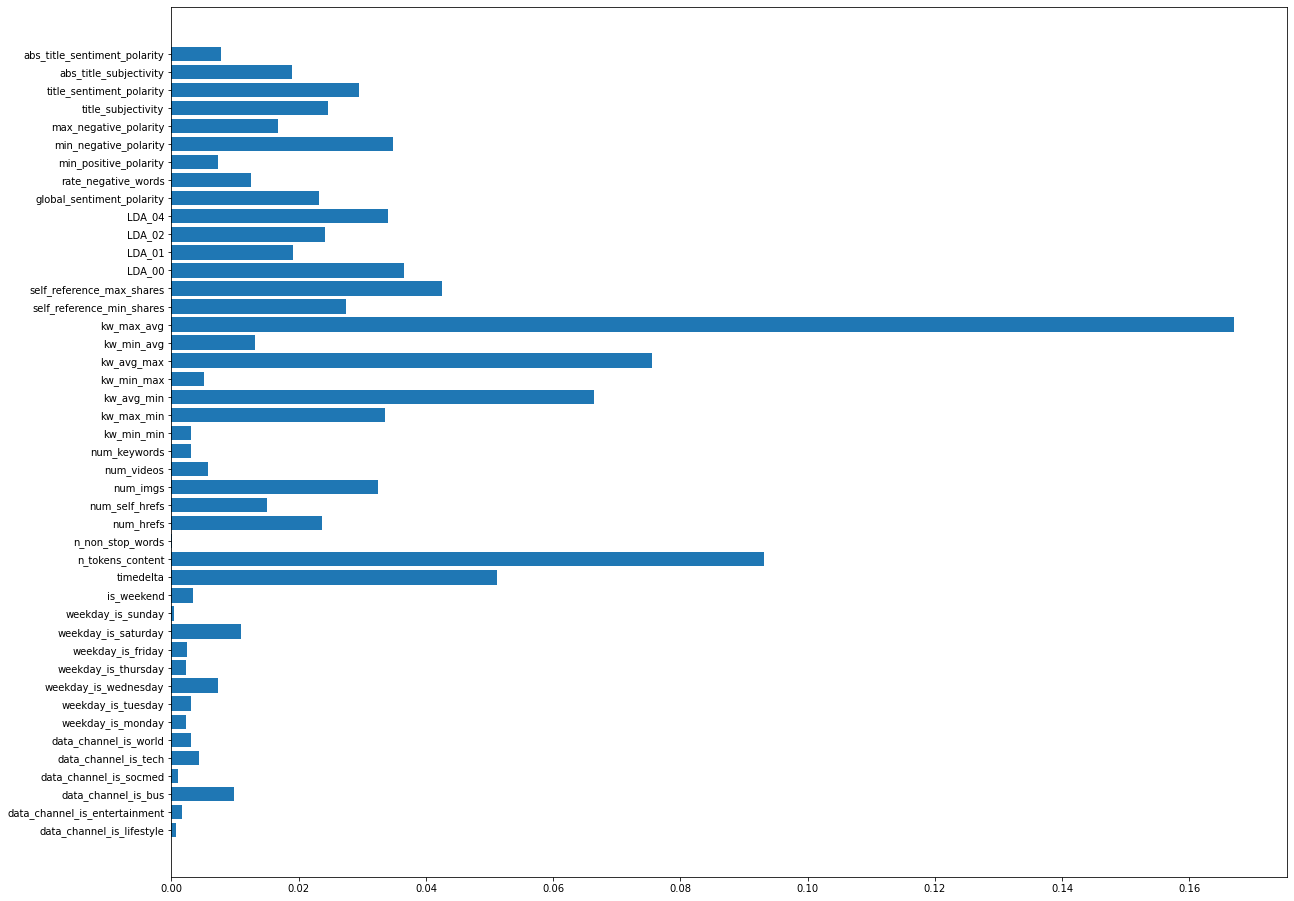

In [ ]:
plt.figure(figsize=(20,16))
ax = plt.barh(list(X_base.columns),reg_rf.feature_importances_)

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*   https://en.wikipedia.org/wiki/Shapley_value



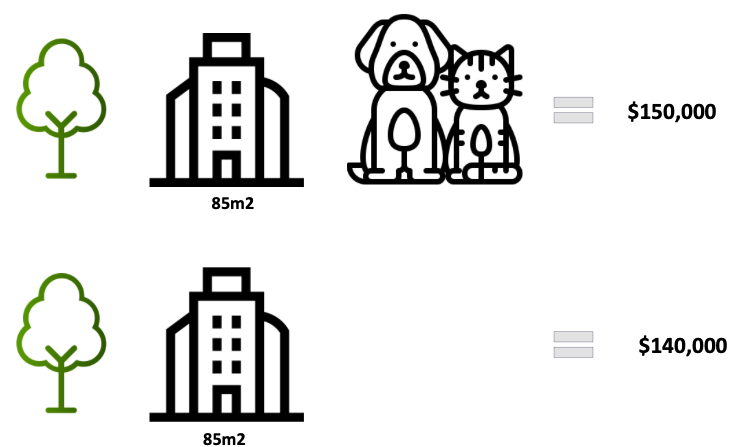

In [ ]:
Image(path_lecture + "img/shapley_value.png")

In [ ]:
explainer = shap.TreeExplainer(reg_rf)
shap_values = explainer.shap_values(X_validation)

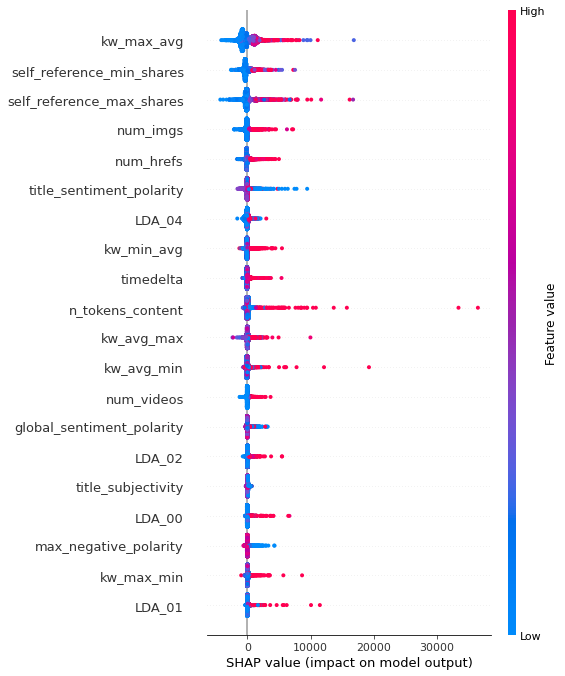

In [ ]:
shap.summary_plot(shap_values, X_validation)